In [1]:
#refered from 
#https://github.com/laituan245/image-segmentation-GMM

In [2]:
import numpy as np
from PIL import Image

COLORS = [ 
    (255, 0, 0),   # red
    (0, 255, 0),  # green
    (0, 0, 255),   # blue
    (255, 255, 0), # yellow
    (255, 0, 255), # magenta
]

def load_image(infilename) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

Iteration 1: Log Likelihood = -75488.02718899067
Iteration 2: Log Likelihood = -66343.74106432626
Iteration 3: Log Likelihood = -59863.57475055533
Iteration 4: Log Likelihood = -55635.32968484613
Iteration 5: Log Likelihood = -51729.64501784279
Iteration 6: Log Likelihood = -49065.85420524773
Iteration 7: Log Likelihood = -47236.804354260705
Iteration 8: Log Likelihood = -45577.095394263815
Iteration 9: Log Likelihood = -44328.24988139709
Iteration 10: Log Likelihood = -43462.317675376136
Iteration 11: Log Likelihood = -42916.85938856273
Iteration 12: Log Likelihood = -42589.073353498745
Iteration 13: Log Likelihood = -42357.8119040301
Iteration 14: Log Likelihood = -42168.85162056513
Iteration 15: Log Likelihood = -42012.68041246037
Iteration 16: Log Likelihood = -41880.26831307011
Iteration 17: Log Likelihood = -41762.78200710835
Iteration 18: Log Likelihood = -41653.19095845244
Iteration 19: Log Likelihood = -41557.528888358975
Iteration 20: Log Likelihood = -41489.35088643784
Itera

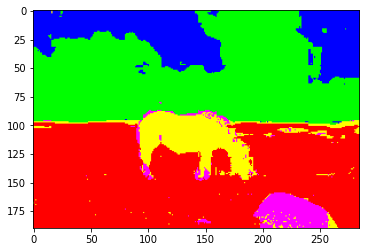

In [3]:
import numpy as np

#from utils import COLORS, load_image
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


class GMM:
    def __init__(self, ncomp, initial_mus, initial_covs, initial_priors):
        self.ncomp = ncomp
        self.mus = np.asarray(initial_mus)
        self.covs = np.asarray(initial_covs)
        self.priors = np.asarray(initial_priors)

    def inference(self, datas): # E-step
        unnormalized_probs = []
        for i in range(self.ncomp):
            mu, cov, prior = self.mus[i, :], self.covs[i, :, :], self.priors[i]
            unnormalized_prob = prior * multivariate_normal.pdf(datas, mean=mu, cov=cov,allow_singular=1)
            unnormalized_probs.append(np.expand_dims(unnormalized_prob, -1))
        preds = np.concatenate(unnormalized_probs, axis=1)
        log_likelihood = np.sum(preds, axis=1)
        log_likelihood = np.sum(np.log(log_likelihood))

        preds = preds / np.sum(preds, axis=1, keepdims=True)
        return np.asarray(preds), log_likelihood

    def update(self, datas, beliefs): # M-step
        new_mus, new_covs, new_priors = [], [], []
        soft_counts = np.sum(beliefs, axis=0)
        for i in range(self.ncomp):
            new_mu = np.sum(np.expand_dims(beliefs[:, i], -1) * datas, axis=0)
            new_mu /= soft_counts[i]
            new_mus.append(new_mu)

            data_shifted = np.subtract(datas, np.expand_dims(new_mu, 0))
            new_cov = np.matmul(np.transpose(np.multiply(np.expand_dims(beliefs[:, i], -1), data_shifted)), data_shifted)
            new_cov /= soft_counts[i]
            new_covs.append(new_cov)

            new_priors.append(soft_counts[i] / np.sum(soft_counts))

        self.mus = np.asarray(new_mus)
        self.covs = np.asarray(new_covs)
        self.priors = np.asarray(new_priors)

if __name__ == '__main__':
    # Load image
    #image_name = raw_input('Input the image name: ')
    image_path = 'horse.jfif'
    image = load_image(image_path)
    image_height, image_width, image_channels = image.shape
    image_pixels = np.reshape(image, (-1, image_channels))
    _mean = np.mean(image_pixels,axis=0,keepdims=True)
    _std = np.std(image_pixels,axis=0,keepdims=True)
    image_pixels = (image_pixels - _mean) / _std # Normalization

    # Input number of classes
    #ncomp = int(input('Input number of classes: '))
    ncomp=5

    # Apply K-Means to find the initial weights and covariance matrices for GMM
    kmeans = KMeans(n_clusters=ncomp)
    labels = kmeans.fit_predict(image_pixels)
    initial_mus = kmeans.cluster_centers_
    initial_priors, initial_covs = [], []
    for i in range(ncomp):
        datas = np.array([image_pixels[j, :] for j in range(len(labels)) if labels[j] == i]).T
        initial_covs.append(np.cov(datas))
        initial_priors.append(datas.shape[1] / float(len(labels)))

    # Initialize a GMM
    gmm = GMM(ncomp, initial_mus, initial_covs, initial_priors)

    # EM Algorithm
    prev_log_likelihood = None
    for i in range(1000):
        beliefs, log_likelihood = gmm.inference(image_pixels) # E-step
        gmm.update(image_pixels, beliefs)   # M-step
        print('Iteration {}: Log Likelihood = {}'.format(i+1, log_likelihood))
        if prev_log_likelihood != None and abs(log_likelihood - prev_log_likelihood) < 1e-10:
            break
        prev_log_likelihood = log_likelihood

    # Show Result
    beliefs, log_likelihood = gmm.inference(image_pixels)
    map_beliefs = np.reshape(beliefs, (image_height, image_width, ncomp))
    segmented_map = np.zeros((image_height, image_width, 3))
    for i in range(image_height):
        for j in range(image_width):
            hard_belief = np.argmax(map_beliefs[i, j, :])
            segmented_map[i,j,:] = np.asarray(COLORS[hard_belief]) / 255.0
    plt.imshow(segmented_map)
    plt.show()
